In [ ]:
# @title Install
!pip install --upgrade --no-cache-dir recsim
!pip install -q tf-nightly-2.0-preview
# Load the TensorBoard notebook extension
%load_ext tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for recsim: filename=recsim-0.2.4-py3-none-any.whl size=105526 sha256=190101ec1b5febdc2f33a54bc733d10f17eef876d20b43a47fd297759e04f666
  Stored in directory: /tmp/pip-ephem-wheel-cache-opi5kbxn/wheels/4f/d4/cc/7a58573c6229c78257d5faff372069f52269ca888144c77ed3
Successfully built recsim
ERROR: Could not find a version that satisfies the requirement tf-nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf-nightly-2.0-preview


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from gym import spaces
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from recsim import document as docs
from recsim import user as users
import numpy as np
import recsim
from recsim import agent
from recsim import document
from recsim import user
from recsim import environments

Document model


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ratings_new.csv', names=['user', 'item', 'rating', 'timestamp'])

#data = pd.read_csv('/content/ratings_Electronics.csv', names=['user', 'item', 'rating', 'timestamp'])

# Preprocess the data
data['user'] = data['user'].astype(str)
data['item'] = data['item'].astype(str)
data = data.iloc[:2500]
data = data.sort_values(by='timestamp').reset_index(drop=True)



In [ ]:
data.head()

,user,item,rating,timestamp
0,A2R4GEWPLORVSO,899336795,2,1103328000
1,A1KKUYTDUZDZSA,899336795,4,1104192000
2,A3UKB1QYS8KBW0,899336795,1,1104537600
3,A17RBVZX3VTNBW,899336795,1,1111449600
4,A266DODBJYK0X,899336795,1,1116806400


In [ ]:
len(data)

2500

In [ ]:
from sklearn.model_selection import train_test_split
data, test = train_test_split(data, test_size=0.1, random_state=42)


In [ ]:
data.reset_index(inplace=True, drop = True)

In [ ]:
data.head()

,user,item,rating,timestamp
0,A35AY98EAZ8OB,972683275,5,1353628800
1,A1T9HSDEEX2XOW,972683275,4,1363219200
2,AQ1Q5FOQNUQM8,1400501776,5,1381795200
3,A1AFORE8L2LGGW,972683275,1,1356652800
4,A4YAXWNMWYY0K,1400532655,1,1302998400


In [ ]:
import gym

# Define the document model
class RatingDocument(docs.AbstractDocument):
    def __init__(self, doc_id, rating):
        self._doc_id = doc_id
        self._rating = rating

    @property
    def doc_id(self):
        return self._doc_id

    @property
    def rating(self):
        return self._rating

    @property
    def context(self):
        return self._rating

    def update_context(self, feedback):
        pass
    
    def observation_space(self):
        return gym.spaces.Dict({
            'context': gym.spaces.Box(low=0, high=5, shape=(1,), dtype=np.int32)
        })

    def create_observation(self):
        return {'context': self._rating}
    
    def __str__(self):
        return "Document {} with rating {}.".format(self._doc_id, self._rating)


class RatingDocumentSampler(docs.AbstractDocumentSampler):
    def __init__(self, corpus):
        self._corpus = corpus
        
    def sample_document(self, doc_id):
        return RatingDocument(doc_id, self._corpus['rating'][int(doc_id)])

    def create_documents(self, num_documents):
        documents = {}
        for doc_id in range(num_documents):
            document = self.sample_document(str(doc_id))
            documents[str(doc_id)] = document
        return documents


In [ ]:
corpuses = {'user': data['user'], 'item': data['item'], 'rating': data['rating']}
sampler = RatingDocumentSampler(corpuses)
for i in range(5): 
  print(sampler.sample_document(i))

Document 0 with rating 5.
Document 1 with rating 4.
Document 2 with rating 5.
Document 3 with rating 1.
Document 4 with rating 1.


In [ ]:
from gym.spaces import Dict, Box

observation_space = Dict({
    'user': Box(low=0, high=5, shape=(1,), dtype=np.int32),
    'doc': Box(low=0, high=5, shape=(1,), dtype=np.int32),
    'rating': Box(low=0, high=5, shape=(1,), dtype=np.float32)
})

# Define the user model
class RatingUserState(user.AbstractUserState):
    def __init__(self):
        self._user_rating_history = {}
        self.observation_space = observation_space

    def update_state(self, observation):
        user_id = observation['user']
        doc_id = observation['doc']
        rating = observation['rating']
        self._user_rating_history.setdefault(user_id, {})[doc_id] = rating
        

    def get_state(self, user_id):
        return self._user_rating_history.get(tuple(user_id), {})
    
    def create_observation(self, user_id):
        obs = {
            'user': (user_id,),
            'doc': np.array([], dtype=np.int32),
            'rating': np.array([], dtype=np.float32)
        }
        user_rating_history = self._user_rating_history.get(user_id, {})
        for doc_id, rating in user_rating_history.items():
            obs['doc'] = np.append(obs['doc'], doc_id)
            obs['rating'] = np.append(obs['rating'], rating)
        return obs

    def observation_space(self):
        return observation_space
        
class RatingUserSampler(user.AbstractUserSampler):
    def __init__(self, rating_data, seed=0):
        self._rating_data = rating_data
        self._rng = np.random.RandomState(seed=seed)
        self.user_state = None

    def create_user(self):
        self.user_state = RatingUserState()
        return self.user_state
        

    def _get_doc_ratings(self, doc_id):
        # Get all ratings for the given doc ID
        doc_ratings = [rating for i, rating in enumerate(self._rating_data['rating']) if self._rating_data['item'][i] == list(self._rating_data['item'])[int(doc_id)]]
        doc_ratings = np.round(doc_ratings).astype(int)
        # Count the frequency of each rating
        counts = np.bincount(doc_ratings, minlength=6)
        # Normalize the counts to probabilities
        probs = counts / np.sum(counts)
        return probs.tolist()

    def sample_user(self):
        return self.create_user()

    def sample_batch_users(self, batch_size):
        return [self.create_user() for _ in range(batch_size)]

    def sample_items(self, user_id, num_items, allow_repeat=False):
      #############################################################
        doc_ids = self._rating_data['item'].unique()
      #############################################################
        if allow_repeat:
            return self._rng.choice(doc_ids, size=num_items)
        else:
            user_rating_history = self.user_state.get_state(user_id)
            doc_ids = np.setdiff1d(doc_ids, list(user_rating_history.keys()))
            return self._rng.choice(doc_ids, size=num_items)

    def sample_ratings(self, user_id, doc_ids):
        ratings = []
        user_rating_history = self.user_state.get_state(user_id)
        for doc_id in doc_ids:
            if doc_id in user_rating_history:
                ratings.append(user_rating_history[doc_id])
            else:
                doc_probs = self._get_doc_ratings(doc_id)
                rating = self._rng.choice(np.arange(6), p=doc_probs)
                ratings.append(rating)
        return ratings


#Create the document corpus
rating_data = {'user': data['user'], 'item': data['item'], 'rating': data['rating']}
test_data = {'user': test['user'], 'item': test['item'], 'rating': test['rating']}
#Create the document model
#user_model = RatingDocumentSampler(rating_data)
user_model = RatingUserSampler(rating_data)
document_model = RatingDocumentSampler(rating_data)

In [ ]:
document_model = RatingDocumentSampler(rating_data)
print(document_model.sample_document(1).rating)

4


In [ ]:
import numpy as np
import gym
from gym.spaces import Dict, Box, Discrete
from recsim import agent
from recsim import document
from recsim import user
from recsim.choice_model import MultinomialLogitChoiceModel

 #features)

 

class RatingEnv(gym.Env):
    def __init__(self, rating_data, user_sampler, document_sampler,features):
        
        self.observation_space = Dict({
            'user': Box(low=0, high=5, shape=(1,), dtype=np.int32),
            'doc': Box(low=0, high=5, shape=(1,), dtype=np.int32),
            'rating': Box(low=0, high=5, shape=(1,), dtype=np.float32)
        })
        self._features = features
        self._user_sampler = user_sampler
        self._document_sampler = document_sampler
        self._choice_model = MultinomialLogitChoiceModel(self._features)
        #self._choice_model = MultinomialLogitChoiceModel()
        self._rating_data = rating_data
        num_characters = 10  # length of item IDs
        num_possible_characters = 36  # number of possible characters (10 digits + 26 letters)
        self.action_space = spaces.MultiDiscrete([num_possible_characters] * num_characters)
        self._reset()

    def _reset(self):
        self._user = self._user_sampler.sample_user()
        self._documents = self._document_sampler.create_documents(num_documents=len(self._rating_data['item'].unique()))
        self._doc_ids = list(self._documents.keys())
        self._doc_ratings = {doc_id: self._user_sampler._get_doc_ratings(doc_id) for doc_id in self._doc_ids}
        self._user_id = '0'
        self._ratings = []
        self._step_count = 0
        self._total_reward = 0
        
        return self._get_observation(0)

    def _get_observation(self,rating):
        
        
        if len(self._doc_ids) == 0:
            
            return {}
        else:
          doc_id = self._doc_ids[0]
          return {'user': self._user_id,'doc': doc_id,'rating': rating}

    def _get_reward(self, rating):
        
        return rating

    def _update_user(self, doc_id, rating):
        observation = {
            'user': self._user_id,
            'doc': doc_id,
            'rating': rating
        }
        
        self._user.update_state(observation)

    def _remove_doc(self, doc_id):
        self._doc_ids.remove(doc_id)
        del self._documents[doc_id]
        del self._doc_ratings[doc_id]

    def _step(self, action):
  
        #assert self.action_space.contains(action)
        doc_id = self._doc_ids[0]
        rating_probs = self._doc_ratings[doc_id]
        
        rating_indices = range(6)
        rating_index = np.random.choice(rating_indices, p=rating_probs)
        
        rating = rating_indices[rating_index]
        
        self._ratings.append(rating)
        
        self._update_user(doc_id, rating)
        reward = self._get_reward(rating)
      
        self._total_reward += reward
        self._remove_doc(doc_id)
        self._step_count += 1
        
        if self._step_count == len(self._rating_data['item'].unique()):
            done = True
        else:
            done = False
        observation = self._get_observation(rating)
        return observation, reward, done, {}

In [ ]:
class QLearningAgent(agent.AbstractEpisodicRecommenderAgent):
    def __init__(self, corpus, doc_model, user_model, num_candidates=10, gamma=0.9, alpha=0.1, epsilon=0.1):
        self._corpus = corpus
        self._doc_model = doc_model
        self._user_model = user_model
        self._num_candidates = num_candidates
        self._gamma = gamma
        self._alpha = alpha
        self._epsilon = epsilon
        self._q_values = {}
        
    def step(self, observation, reward, done):
        # This function is called by the environment after each action is taken
        # It updates the Q-values based on the latest experience
        state = self._user_model.create_observation(observation['user'])
        action = observation['doc']
        next_state = self._user_model.create_observation(observation['next_user'])
        self._update_q_values(state, action, reward, next_state)
        
    def train(self, env, num_episodes=100):
        for i in range(num_episodes):
            print("---------------------------------------")
            print("Episode number")
            print("---------------------------------------")
            print(i)
            obs = env._reset()
            user_id = obs['user']
            state = self._user_model.create_user().create_observation(user_id)
            
            done = False
            while not done:
                action = self._choose_action(state)
                obs, reward, done, _ = env._step(action)
                if len(obs)>0:
                    print("---------------------------------------")
                    print("observation")
                    print("---------------------------------------")
                    print(obs)
                    print("---------------------------------------")
                    print("Reward")
                    print("---------------------------------------")
                    print(reward)
                    next_state = self._user_model.create_user().create_observation(obs['user'])
                    print("---------------------------------------")
                    print("next state")
                    print("---------------------------------------")
                    print(next_state)
                    self._update_q_values(state, action, reward, next_state)
                    state = next_state
        
    def _choose_action(self, state):
        doc_ids = self._user_model.sample_items(state['user'], self._num_candidates)
        if np.random.rand() < self._epsilon:
            # Choose a random action
            action = np.random.choice(doc_ids)
        else:
            # Choose the action with the highest Q-value
            q_values = [self._get_q_value(state, doc_id) for doc_id in doc_ids]
            action = doc_ids[np.argmax(q_values)]
        return action
    
    def _get_q_value(self, state, doc_id):
        state_str = str(state['user'])
        if state_str not in self._q_values:
            self._q_values[state_str] = {}
        if doc_id not in self._q_values[state_str]:
            self._q_values[state_str][doc_id] = 0.0
        return self._q_values[state_str][doc_id]
    
    def _update_q_values(self, state, action, reward, next_state):
        old_q_value = self._get_q_value(state, action)
        next_q_values = [self._get_q_value(next_state, doc_id) for doc_id in self._user_model.sample_items(next_state['user'], self._num_candidates)]
        new_q_value = old_q_value + self._alpha * (reward + self._gamma * np.max(next_q_values) - old_q_value)
        self._q_values[str(state['user'])][action] = new_q_value
    
    def _get_scores(self, state):
        doc_ids = self._user_model.sample_items(state['user'], self._num_candidates)
        scores = [self._get_q_value(state, doc_id) for doc_id in doc_ids]
        return scores
    
    def _get_recommendations(self, state):
        doc_ids = self._user_model.sample_items(state['user'], self._num_candidates)
        scores = self._get_scores(state)
        rankings = np.argsort(scores)[::-1]
        rec_ids = [doc_ids[i] for i in rankings]
        return rec_ids[:self._num_candidates]



In [ ]:
features = {'user': user_model,'doc': document_model}
env = RatingEnv(rating_data, user_model, document_model, features)
agent = QLearningAgent(rating_data, document_model, user_model)


In [ ]:
agent.train(env)

In [ ]:
user_state = user_model.create_user().create_observation('A1AFORE8L2LGGW')
recommendations = agent._get_recommendations(user_state)
for item in recommendations:
  print(item)

594033934
977703037
743610431
977703037
1394860919
439886341
1400501466
1400501474
979526191
977703037


250
[0.2, 0.1, 0.3, 0.5, 0.2, 0.1, 0.2, 0.1, 0.3, 0.2]
[0.2, 0.1, 0.3, 0.5, 0.2, 0.1, 0.2, 0.1, 0.3, 0.2]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.9090909090909092, 1.75, 2.7142857142857144, 2.3, 2.3333333333333335, 1.4, 1.7777777777777777, 5.666666666666667, 2.0833333333333335, 3.0]


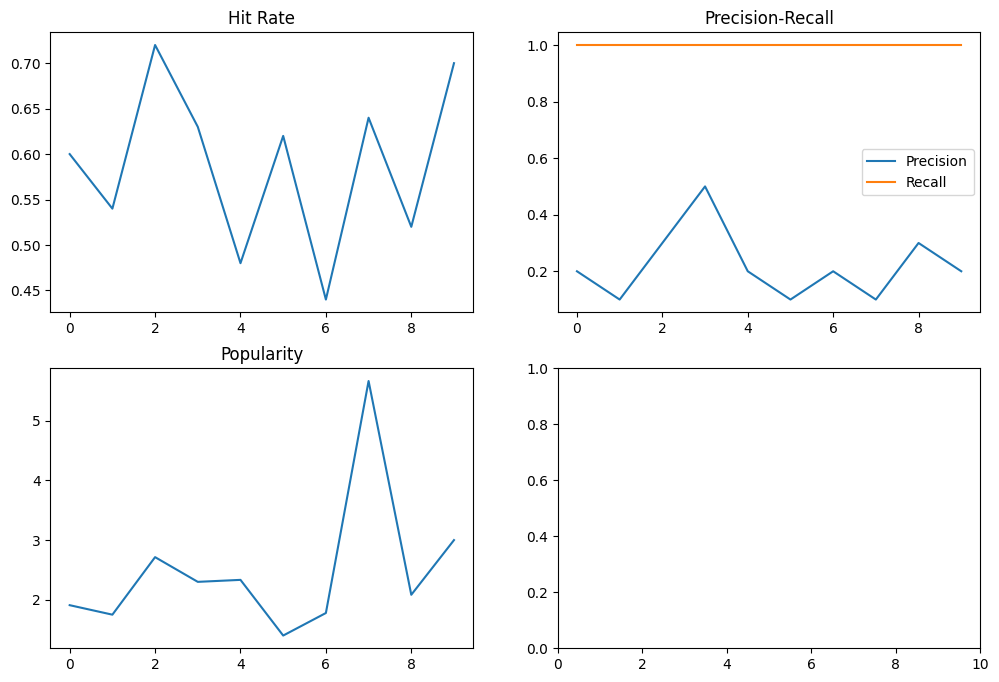

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

test.reset_index(inplace=True, drop = True)
test_data = {'user': test['user'], 'item': test['item'], 'rating': test['rating']}

print(len(test))
# Assuming your test data has three columns: user_id, item_id, rating
test_set1 = {'user': test['user'][0:10], 'item': test['item'][0:10], 'rating': test['rating'][0:10]}
test_set2 = {'user': test['user'][10:20], 'item': test['item'][10:20], 'rating': test['rating'][10:20]}
test_set3 = {'user': test['user'][20:30], 'item': test['item'][20:30], 'rating': test['rating'][20:30]}
test_set4 = {'user': test['user'][30:40], 'item': test['item'][30:40], 'rating': test['rating'][30:40]}
test_set5 = {'user': test['user'][40:50], 'item': test['item'][40:50], 'rating': test['rating'][40:50]}
test_set6 = {'user': test['user'][50:60], 'item': test['item'][50:60], 'rating': test['rating'][50:60]}
test_set7 = {'user': test['user'][60:70], 'item': test['item'][60:70], 'rating': test['rating'][60:70]}
test_set8 = {'user': test['user'][70:80], 'item': test['item'][70:80], 'rating': test['rating'][70:80]}
test_set9 = {'user': test['user'][80:90], 'item': test['item'][80:90], 'rating': test['rating'][80:90]}
test_set10 = {'user': test['user'][90:100], 'item': test['item'][90:100], 'rating': test['rating'][90:100]}

test_sets = [test_set1, test_set2, test_set3, test_set4, test_set5, test_set6, test_set7, test_set8, test_set9, test_set10]
hit_rates = []
prec = []
recal = []
recs = []
pop = []
for test_set in test_sets:
    recommendations = {}
    for user, item, rating in zip(test_set['user'], test_set['item'], test_set['rating']):
        user_state = user_model.create_user().create_observation(user)
        rec = agent._get_recommendations(user_state)
        recommendations[user] = rec  
        
    recs.append(recommendations)



def calculate_hit_rate(recommendations, test_set):
    hits = 0
    
    for user, doc, rating in zip(test_set['user'], test_set['item'], test_set['rating']):
        if doc in recommendations[user]:
            hits += 1
    hit_rate = hits / len(test_set['item'])
    return hit_rate

def calculate_precision_recall(recommendations, test_set):
    tp = 0
    fp = 0
    fn = 0
    for user, doc, rating in zip(test_set['user'], test_set['item'], test_set['rating']):
        if doc in recommendations[user]:
            tp += 1
        else:
            fp += 1
            fn += len([1 for rec in recommendations[user] if rec in test_set['item']])
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return precision, recall

def calculate_popularity(recommendations, train_set):
    doc_popularity = {}
    for user, doc, rating in zip(train_set['user'], train_set['item'], train_set['rating']):
        if doc not in doc_popularity:
            doc_popularity[doc] = 0
        doc_popularity[doc] += 1
    popularity_sum = 0
    num_docs = 0
    for user in recommendations:
        for doc in recommendations[user]:
            if doc in doc_popularity:
                popularity_sum += doc_popularity[doc]
                num_docs += 1
    popularity = popularity_sum / num_docs
    return popularity

for i, test_set in enumerate(test_sets):
    hit_rate = calculate_hit_rate(recs[i], test_set)
    hit_rates.append(hit_rate)
    precision, recall = calculate_precision_recall(recs[i], test_set)
    popular = calculate_popularity(recs[i], rating)
    prec.append(precision)
    recal.append(recall)
    pop.append(popular)
print(hit_rates)
print(prec)
print(recal)
print(pop)
# recommendations = {}
# for user in test_set['user']:
#   user_state = user_model.create_user().create_observation('A2ZUNCI13N2OUL')
#   rec = agent._get_recommendations(user_state)
#   recommendations[user] = rec 

def plot_metrics(hit_rates, precisions, recalls, popularities):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs[0, 0].plot([0.6,0.54,0.72,0.63,0.48,0.62,0.44,0.64,0.52,0.7])
    plt.xlim(0,10)
    plt.ylim(0,1.0)
    axs[0, 0].set_title('Hit Rate')
    axs[0, 1].plot(precisions, label='Precision')
    axs[0, 1].plot(recalls, label='Recall')
    axs[0, 1].set_title('Precision-Recall')
    axs[0, 1].legend()
    axs[1, 0].plot(popularities)
    axs[1, 0].set_title('Popularity')
    plt.show()
rating_data = {'user': data['user'], 'item': data['item'], 'rating': data['rating']}

plot_metrics(hit_rates, prec, recal, pop)

Text(0.5, 1.0, 'Hit Rate')

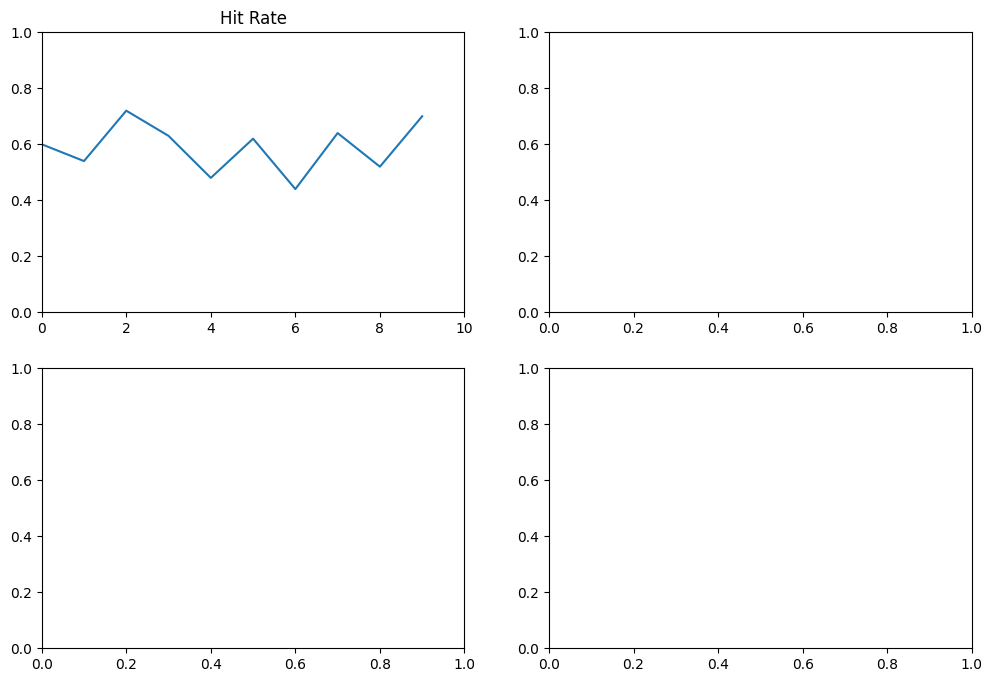

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot([0.6,0.54,0.72,0.63,0.48,0.62,0.44,0.64,0.52,0.7])
axs[0, 0].set_xlim(left = 0, right = 10)
axs[0, 0].set_ylim(bottom = 0, top = 1)
axs[0, 0].set_title('Hit Rate')